<a href="https://colab.research.google.com/github/ajinkyasakhare19/MyThesis/blob/master/NN_Hands_on_Breast_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
!pip install deap
import random
import numpy as np
import pandas as pd
from deap import base
from deap import creator
from deap import tools,algorithms

In [113]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
MAX_ACCURACY = 1.0
MAX_ERROR = 0.0


/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [114]:
IND_SIZE=569#257
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform,-1,1)
toolbox.register("individual", tools.initRepeat, creator.Individual,toolbox.attr_float, n=IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [115]:
from sklearn.model_selection import train_test_split #used for split the data in to train and test
from sklearn.preprocessing import StandardScaler #used for the scal the data
data = pd.read_csv('datasets_180_408_data.csv') #load data from csv in to variable using pandas read_csv funcion

#differentiate input data and result data from dataset

##for input data take all the columns excluding ['ID', 'Diagnosis' , 'UNNAMED:32'] Columns 
input_Data = data.drop(columns=['id','diagnosis','Unnamed: 32']) 

##for result data take diagnosis column values as "0 for M('Malignant')" and "1 for B('Benign')"
result_Data = data['diagnosis'].map({'M':0,'B':1})
# here we does not have any Test-Set data & Training-Set data
# So we will differentiate teat & traing data from input and result data which we prepared
# that can be done by using sklearn library's model_selection module's function train_test_split()

train_data, test_data, train_label, test_label = train_test_split(input_Data, result_Data, test_size=0.30)
# Now scal the data in between 0 to 1 for prosessing
# using StandardScaler() module of sklearn.preprocessing

scaler = StandardScaler()
N_train_data = scaler.fit_transform(train_data) # this is normalized training data
N_test_data = scaler.fit_transform(test_data) # this is normalized testing data


X=N_train_data
y=train_label
print(X.shape)

(398, 30)


In [116]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# Imports
import numpy as np 

from sklearn import metrics
# Define useful functions    

# Activation function
def sigmoid(t):
    return 1/(1+np.exp(-t))

def chunks(lst, n):
  data = np.array(lst)
  shape=(int(len(lst)/n),n)
  #print(type(shape))
  data=data.reshape(shape)
  #print(data)
  return(data)

def network_config(ind):
    weight_hidden=(chunks(ind[:240],8))
    weight_output=(np.asarray(chunks(ind[240:496],32)))
    weight_output1=(np.asarray(chunks(ind[496:528],1)))
    bias_hidden=np.asarray(ind[528:536])
    bias_weight=np.asarray(ind[536:568])
    bias_weight1=np.asarray(ind[568])
    network_config={
        "W1":weight_hidden,
        "W2":weight_output,
        "W3":weight_output1,
        "b1":bias_hidden,
        "b2":bias_weight,
        "b3":bias_weight1
    }
    #print(network_config["W1"].shape)
    return network_config

# Class definition
class NeuralNetwork:
    def __init__(self, x,y,network_config):
        self.input = x
        self.weights1= network_config["W1"] # considering we have 4 nodes in the hidden layer
        self.weights2 = network_config["W2"]
        self.weights3 = network_config["W3"]
        self.bias1=network_config["b1"]
        self.bias2=network_config["b2"]
        self.bias3=network_config["b3"]
        self.y = y
        self.output = np. zeros(y.shape)
        
    def feedforward(self):
        self.layer1 = sigmoid(np.dot(self.input, self.weights1)+self.bias1)
        self.layer2 = sigmoid(np.dot(self.layer1, self.weights2)+self.bias2)
        self.layer3 = sigmoid(np.dot(self.layer2, self.weights3)+self.bias3)
        return self.layer3

    def train(self, X, y):
        self.output = self.feedforward()
        
    def predict(self):
        Ypred=[]
        Yhat=self.feedforward()
        for y in Yhat:
            if y<0.5:
                Ypred.append([0])
            else:Ypred.append([1])
        return np.asarray(Ypred)

In [117]:
def evalOneMax(individual):
    config=network_config(individual)    
    NN = NeuralNetwork(X,y,config)
    pred=NN.predict()
    from sklearn import metrics
    return (metrics.accuracy_score(y,np.asarray(pred).flatten()),)

In [118]:
def rsme(individual):
    config=network_config(individual)    
    NN = NeuralNetwork(X,y,config)
    pred=NN.predict()
    from sklearn import metrics
    return (metrics.mean_squared_error(y,np.asarray(pred).flatten()),)

In [119]:
from sklearn import metrics
def fitness(individual):
    config=network_config(individual)    
    NN = NeuralNetwork(X,y,config)
    pred=NN.predict()
    accu=metrics.accuracy_score(y,np.asarray(pred).flatten())
    err=metrics.mean_squared_error(y,np.asarray(pred).flatten())
    # Limit Conditions
    if accu > MAX_ACCURACY or err < MAX_ERROR:
        return 10000, 0.0000001

    return accu , err,


In [165]:
toolbox.register("evaluate", rsme)
toolbox.register("mate", tools.cxBlend,alpha=0.3)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selBest)
#toolbox.register("select", tools.selTournament, tournsize=5)
#toolbox.register("select", tools.selNSGA2)

In [174]:
import numpy
def main():
    pop = toolbox.population(n=500)
    hof = tools.HallOfFame(10,similar=numpy.array_equal)
    #print(pop)
    fitnesses = list(map(toolbox.evaluate, pop))
    print(fitnesses)
    print(len(fitnesses))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    CXPB, MUTPB = 0.7, 0.4
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    pop_simple, logbook_simple= algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=500,stats=stats,verbose=False,halloffame=hof)
    return(pop_simple, logbook_simple,hof)

In [144]:
"""import numpy
def main():
    pop = toolbox.population(n=500)
    hof = tools.HallOfFame(10,similar=numpy.array_equal)
    hof_muLambda = tools.HallOfFame(10,similar=numpy.array_equal)
    #print(pop)
    MU, LAMBDA = 100, 200
    fitnesses = list(map(toolbox.evaluate, pop))
    print(fitnesses)
    print(len(fitnesses))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    CXPB, MUTPB = 0.7, 0.3
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    pop_muLambda, logbook_muLambda= algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
                                             cxpb=CXPB, mutpb=MUTPB, ngen=80, 
                                           stats=stats, halloffame=hof_muLambda)
    #pop_simple, logbook_simple=algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=200,stats=stats,verbose=False,halloffame=hof)
    return(pop_muLambda, logbook_muLambda,hof_muLambda)#, pop_muLambda, logbook_muLambda,hof_muLambda)"""

[(0.3542713567839196,), (0.6206030150753769,), (0.6206030150753769,), (0.6206030150753769,), (0.6206030150753769,), (0.3793969849246231,), (0.5628140703517588,), (0.6206030150753769,), (0.6206030150753769,), (0.6206030150753769,), (0.3793969849246231,), (0.42462311557788945,), (0.6206030150753769,), (0.6206030150753769,), (0.3793969849246231,), (0.6331658291457286,), (0.6231155778894473,), (0.6206030150753769,), (0.6206030150753769,), (0.6206030150753769,), (0.3793969849246231,), (0.3793969849246231,), (0.3793969849246231,), (0.37185929648241206,), (0.3793969849246231,), (0.6206030150753769,), (0.3793969849246231,), (0.8190954773869347,), (0.6206030150753769,), (0.3793969849246231,), (0.6206030150753769,), (0.7763819095477387,), (0.3542713567839196,), (0.6859296482412061,), (0.6206030150753769,), (0.3793969849246231,), (0.6206030150753769,), (0.635678391959799,), (0.6206030150753769,), (0.6206030150753769,), (0.6206030150753769,), (0.3793969849246231,), (0.7110552763819096,), (0.814070

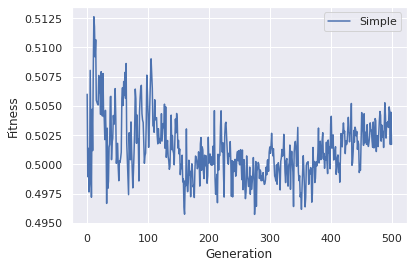

CPU times: user 13min 40s, sys: 8min 15s, total: 21min 55s
Wall time: 12min 11s


In [175]:
%%time
if __name__ == "__main__":
    pop_simple, logbook_simple,hof=main()
    import matplotlib.pyplot as plt
    gen, avg, min_, max_simple = logbook_simple.select("gen", "avg", "min", "max")
    #gen_muLambda, avg_muLambda, min_muLambda, max_muLambda = logbook_muLambda.select("gen", "avg", "min", "max")
    plt.plot(gen, avg, label="Simple")
    #plt.plot(gen_muLambda, avg_muLambda, label="MuLambda")
    print(hof)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend()
    plt.show()


In [176]:
len(hof)

10

In [177]:
logbook_simple

[{'avg': 0.506,
  'gen': 0,
  'max': 0.8618090452261307,
  'min': 0.09798994974874371,
  'nevals': 0},
 {'avg': 0.4989497487437186,
  'gen': 1,
  'max': 0.8994974874371859,
  'min': 0.09798994974874371,
  'nevals': 407},
 {'avg': 0.5013768844221106,
  'gen': 2,
  'max': 0.871859296482412,
  'min': 0.08793969849246232,
  'nevals': 395},
 {'avg': 0.4976482412060301,
  'gen': 3,
  'max': 0.8467336683417085,
  'min': 0.1407035175879397,
  'nevals': 425},
 {'avg': 0.49836683417085426,
  'gen': 4,
  'max': 0.8844221105527639,
  'min': 0.11809045226130653,
  'nevals': 419},
 {'avg': 0.5080402010050251,
  'gen': 5,
  'max': 0.8844221105527639,
  'min': 0.14824120603015076,
  'nevals': 409},
 {'avg': 0.5023316582914572,
  'gen': 6,
  'max': 0.8467336683417085,
  'min': 0.11055276381909548,
  'nevals': 413},
 {'avg': 0.4971959798994975,
  'gen': 7,
  'max': 0.9271356783919598,
  'min': 0.08542713567839195,
  'nevals': 408},
 {'avg': 0.5047135678391959,
  'gen': 8,
  'max': 0.9271356783919598,
  

In [178]:
print(len(hof))

from sklearn import metrics
train_acc=[]
test_acc=[]
for ho in hof:
  print("Train")
  config=network_config(ho) 
  NN = NeuralNetwork(N_train_data,train_label,config)
  pred=NN.predict()
  tr_acc=metrics.accuracy_score(train_label,np.asarray(pred).flatten())
  train_acc.append(tr_acc)
  print(tr_acc)
  print("Test")
  config=network_config(ho) 
  NN = NeuralNetwork(N_test_data,test_label,config)
  pred=NN.predict()
  te_acc=metrics.accuracy_score(test_label,np.asarray(pred).flatten())
  test_acc.append(te_acc)
  print(te_acc)
  print("---------------------")

10
Train
0.9371859296482412
Test
0.9005847953216374
---------------------
Train
0.9371859296482412
Test
0.8654970760233918
---------------------
Train
0.9346733668341709
Test
0.9181286549707602
---------------------
Train
0.9346733668341709
Test
0.9005847953216374
---------------------
Train
0.9321608040201005
Test
0.8421052631578947
---------------------
Train
0.9321608040201005
Test
0.8888888888888888
---------------------
Train
0.9296482412060302
Test
0.8947368421052632
---------------------
Train
0.9296482412060302
Test
0.9005847953216374
---------------------
Train
0.9271356783919598
Test
0.8771929824561403
---------------------
Train
0.9246231155778895
Test
0.8713450292397661
---------------------


In [179]:
np.asarray(train_acc).mean()

0.9319095477386934

In [180]:
np.asarray(test_acc).mean()

0.8859649122807017

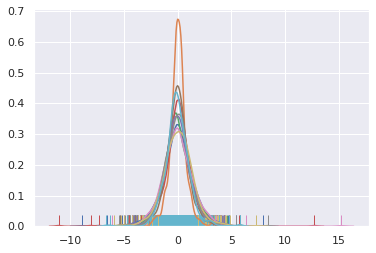

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
for i in range(len(hof)):
  sns.distplot(hof[i],hist=False, rug=True)